# Getting started with packages imports and git repo cloning

* https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb
* https://medium.com/mantisnlp/how-to-combine-several-embeddings-models-8e7bc9a00330
* https://distill.pub/2021/gnn-intro/
* https://bojarlab.github.io/glycowork/glycan_data.html
* https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1
* https://academic.oup.com/glycob/article/31/10/1240/6311240#312815562

In [52]:
!git clone -b phi https://github.com/PhiCtl/isospec-internship/

fatal: destination path 'isospec-internship' already exists and is not an empty directory.


In [53]:
!pip install "glycowork[ml]" nbdev glycowork

In [54]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from nbdev.showdoc import show_doc

import numpy as np
import pandas as pd
import os
import copy

from torch_geometric.nn import TopKPooling, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
import torch

from glycowork.ml.models import *
from glycowork.ml.inference import *
from glycowork.ml.processing import *
from glycowork.ml.model_training import *
from glycowork.ml.train_test_split import *
from glycowork.glycan_data.loader import df_species, df_glycan, glycan_binding

In [70]:
import copy

In [55]:
DATA_PATH = "/content/isospec-internship/data/glycan_embedding"

# Datasets

In [56]:
# Extracted glycans used for inference and enrichment
df_glycan_list = pd.read_csv(os.path.join(DATA_PATH, 'glycan_list.csv'))
df_glycan_list

,glycan,Composition,tissue_species,tissue_sample
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood']
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood']
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood']
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood']
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood']


In [57]:
df_glycan = df_glycan[~df_glycan['glycan'].isin(df_glycan_list['glycan'].to_list())] # Remove glycans of interest from the curated list...
df_glycan.shape

(50589, 23)

In [58]:
print(f"There are {df_glycan.explode('Species')['Species'].nunique()} unique species in the data set",
         f"and {df_glycan.explode('disease_association')['disease_association'].nunique()} diseases.")

There are 2793 unique species in the data set and 60 diseases.


In [75]:
df_glycan.explode('disease_association')['disease_association'].value_counts().reset_index()

,disease_association,count
0,,1567
1,colorectal_cancer,370
2,pancreatic_cancer,64
3,cholangiocarcinoma,59
4,stomach_cancer,56
5,liver_cancer,53
6,female_breast_cancer,49
7,esophageal_cancer,41
8,lung_non_small_cell_carcinoma,39
9,prostate_cancer,24


In [60]:
glycan_binding.shape

(1465, 2745)

In [61]:
# Used to control representation in the embedding space by assessing closeness
df_N_glycans = pd.read_csv(os.path.join(DATA_PATH, 'N_glycans_df.csv'))

In [62]:
df_N_glycans.shape

(48, 24)

# Approaches reflexion

Getting inspiration from [Using graph convolutional neural networks to learn a representation for glycans](https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1) :
* Sweetnet is a graph convolutional network (GCNN) that provides a useful glycan representation using glycan sequences.
* Sweetnet was trained using _the task of predicting which species a given glycan sequence came from_, ie. a multiclass classification task for a better model performance comparison. The GCNN approach outperformed existing approaches on the classification task. See more about Sweetnet training [here](https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb).
* Sweetnet was also pretrained using _a context prediction task in which the model is used to predict the identity of a randomly chosen hidden node, given the connectivities and the other nodes in a glycan_ before being fine-tuned on the classification task.

The state of the art embedding for glycans from different species is already computed by Sweetnet graph. Using graph neural networks seems the best possible approach. Nevertheless, different approaches for embedding can be used:
* Take advantage of curated Sweetnet GCNN architecture for glycan sequence embedding, train the model on human-tissues-collected glycans sequences with the task of predicting the associated diseases. ``` composition ``` and ```tissue_sample``` features could be leveraged for embedding space learning as well, but 1) ```composition``` is redundant with the glycan sequence and 2) ```tissue_sample``` might not exactly reflect glycan presence in tissues.
*  Using Sweetnet embedding to validate
* Explore another type of graph neural network architecture, namely graph transformers ([See HugginFace website](https://huggingface.co/docs/transformers/en/model_doc/graphormer#usage-tips)).



# 1 - Taking advantage of Sweetnet architecture

The main issue is that disease class distribution is highly unbalanced and that there is only 1 data point having a disease association with lung cancer.

## 1-1 Data processing

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_val_split(df_in, val_size=0.2, seed=42, min_samples=3, class_type='disease_association'):

  df = df_in.explode(class_type)
  class_list = list(set(df[class_type].to_list()))
  class_counts = df[class_type].value_counts().reset_index()

  # Drop classes with small number of samples
  classes_to_drop = [c[class_type] for _, c in class_counts.iterrows() if c['count'] < min_samples]
  df = df[~df[class_type].isin(classes_to_drop)]
  class_map = { c : k for k, c in enumerate(class_list)}
  df[class_type] = df[class_type].map(class_map)

  # Get splits
  sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
  sss.get_n_splits(df['glycan'].values.to_list(), df[class_type].values.to_list())
  train_index, test_index = next(sss.split(df['glycan'].values.to_list(), df[class_type].values.to_list()))
  train_x = df.iloc[train_index]['glycan']
  train_y = df.iloc[train_index][class_type]
  val_x = df.iloc[test_index]['glycan']
  val_y = df.iloc[test_index][class_type]

  return train_x, train_y, val_x, val_y, test_index, class_list, class_map

In [67]:
df_data = df_glycan.explode('Species')
df_data = df_data[df_data['Species'] == 'Homo_sapiens'].explode('disease_association').drop_duplicates(['glycan', 'Species', 'disease_association'])
df_data.shape

(5590, 23)

In [ ]:
df_data['disease_association'].value_counts()

In [ ]:
df_data = df_glycan.explode('Species')
df_data = df_data[df_data['Species'] == 'Homo_sapiens']

In [ ]:
lib = get_lib(df_data['glycan'].to_list())
train_x, train_y, val_x, val_y, test_index, class_list, class_map = train_val_split(df_data)

glycan_graphs_train = dataset_to_graphs(train_x, train_y, libr = lib)
glycan_graphs_val = dataset_to_graphs(val_x, val_y, libr = lib)

train_loader = DataLoader(glycan_graphs_train, batch_size = 32, shuffle = True)
val_loader = DataLoader(glycan_graphs_val, batch_size = 32, shuffle = False)
dataloaders = {'train':train_loader, 'val':val_loader}

## 1-2 Model training

In [ ]:
model = SweetNet(lib_size=len(lib), num_classes=len(class_list))
model.apply(init_weights)
model.cuda()

early_stopping = EarlyStopping(patience = 50, verbose = True)
optimizer_ft = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 50)
criterion = torch.nn.CrossEntropyLoss().cuda()

In [ ]:
model_ft = train_model(model, criterion, optimizer_ft, scheduler,
                  num_epochs = 100)

## 1-3 Analyse model

In [ ]:
analyze_ml_model(model_ft)

# 2- Using pre-trained Sweetnet for properties inference

In [9]:
model = prep_model('SweetNet', trained=True, num_classes=1011)
glycans = df_glycan_list['glycan'].to_numpy()

df_learned_rep = glycans_to_emb(glycans, model)
df_learned_rep['glycan'] = df_glycan_list['glycan']
df_learned_rep['type'] = ['unknown'] * len(df_learned_rep)
df_learned_rep.head()

Downloading...
From: https://drive.google.com/uc?id=1arIT31FpA1FCKSDVUuntc9-UQEUpcXVz
To: /content/SweetNet_v1_4.pt
100%|██████████| 3.31M/3.31M [00:00<00:00, 26.6MB/s]


Download completed.


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,glycan,type
0,-0.794141,-0.075739,-0.099164,0.726709,0.484261,0.070893,-0.756496,-0.204407,0.055970,-0.106668,...,0.481233,0.159814,0.675465,0.173172,0.157147,-0.082026,-0.173163,-0.449195,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,unknown
1,-0.649488,-0.155966,0.530374,0.360211,0.247192,-0.063482,-0.621762,-0.005740,0.590882,0.361569,...,-0.070064,-0.821788,0.703040,0.204986,0.109358,-0.139274,0.202473,-0.726340,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,unknown
2,-0.574490,-0.104015,-0.097022,0.506985,0.128725,-0.525511,-0.147155,-0.002637,0.141030,0.261282,...,0.409167,-0.540376,-0.123692,0.397333,0.210452,-0.353647,0.439389,-0.438737,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,unknown
3,-0.710714,0.032203,-0.282862,0.587875,0.076552,-0.778691,-0.137108,-0.072778,-0.031902,0.353800,...,0.508384,-0.626425,-0.098453,0.369425,0.176167,-0.452234,0.467732,-0.455071,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,unknown
4,-0.673734,0.372437,-0.098899,0.576456,0.379758,0.199676,-0.296903,0.052517,0.298453,0.545761,...,0.185924,0.356945,0.357075,0.143403,0.357225,0.297999,0.403833,-0.739958,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,unknown


In [20]:
human_n_glycans = df_N_glycans.explode('Species').drop_duplicates(['Species', 'glycan'])
df_learned_rep_N = glycans_to_emb(human_n_glycans['glycan'].to_numpy(), model)
df_learned_rep_N['glycan'] = human_n_glycans['glycan']
df_learned_rep_N['type'] = ['N_glycan'] * len(df_learned_rep_N)
print(df_learned_rep_N.shape)

(48, 130)


In [12]:
human_glycans = df_glycan.explode('tissue_species')
human_glycans = human_glycans[human_glycans['tissue_species'] == 'Homo_sapiens'].drop_duplicates(['glycan', 'tissue_species'])
glycans_exhaustive = human_glycans['glycan'].to_numpy()
df_learned_rep_exhaustive = glycans_to_emb(glycans_exhaustive, model)
df_learned_rep_exhaustive['glycan'] = human_glycans['glycan'].to_numpy()
df_learned_rep_exhaustive['type'] = ['known'] * len(df_learned_rep_exhaustive)

In [16]:
df_learned_rep_exhaustive.shape

(3820, 130)

In [21]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne_emb = TSNE(random_state = 42).fit_transform(pd.concat([df_learned_rep_exhaustive, df_learned_rep, df_learned_rep_N]).drop(['glycan', 'type'], axis=1))

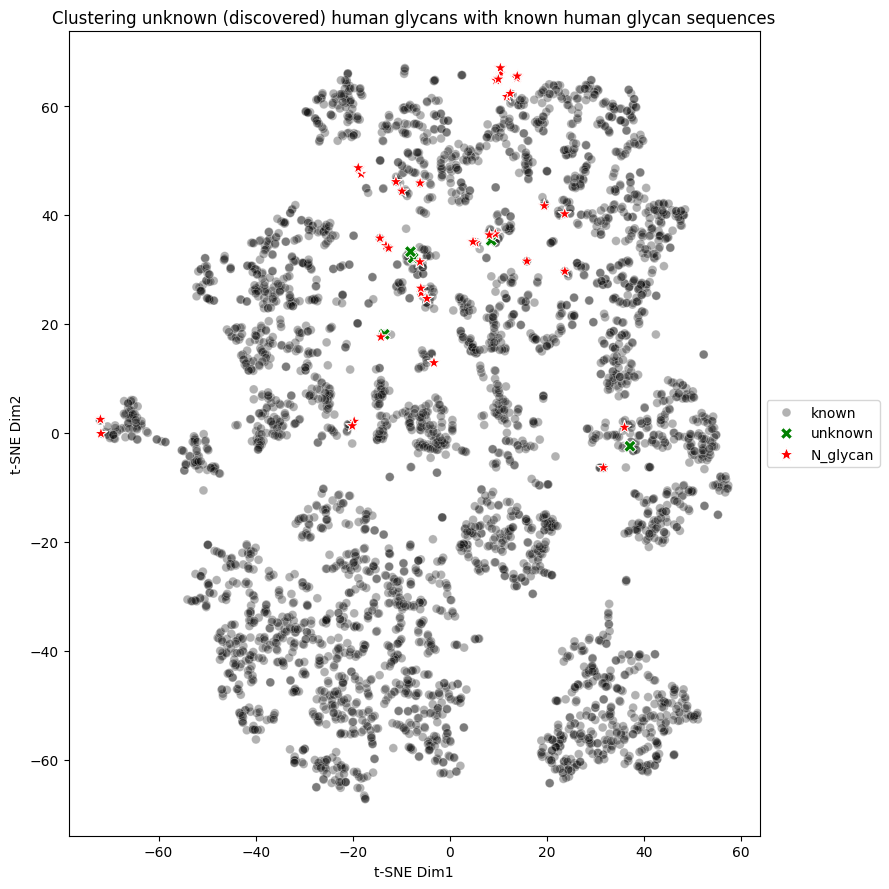

In [24]:
plt.figure(figsize = (9, 9))
sns.scatterplot(x = tsne_emb[:3820,0], y = tsne_emb[:3820,1], s = 40, alpha = 0.3,
                hue = df_learned_rep_exhaustive['type'].values.tolist(), palette=['black'])
sns.scatterplot(x = tsne_emb[3820:3825,0], y = tsne_emb[3820:3825,1], s = 80,
                hue = df_learned_rep['type'].values.tolist(), marker='X', palette=['green'])
sns.scatterplot(x = tsne_emb[-48:,0], y = tsne_emb[-48:,1], s = 100,
                hue = df_learned_rep_N['type'].values.tolist(), marker='*', palette=['red'])
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Clustering unknown (discovered) human glycans with known human glycan sequences')
plt.tight_layout()

## Cluster data points

Using learned embeddings, find which clusters the 5 glycans of interest belong to.

In [ ]:
from sklearn.neighbors import NearestNeighbors